## 1.5 Batch Normalization in action


Now let's create a layer to use batch normalization easier.

In [1]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Layer, Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.utils import to_categorical

In [2]:
class BatchNormalizedLayer(Layer):
  def __init__(self, layer, axis=-1, activation=None, **kwargs):
    """Runs batch normalization on layer instance and applies the activation function
    
    Args:
      layer(layers.Layer): A layer to normalize its output
      axis(int): the axis that should be normalized (typically the features axis).
      activation(str): Activation function to use
    """
    super(BatchNormalizedLayer, self).__init__(**kwargs)
    
    self.layer = layer
    self.activation = Activation(activation=activation)
    self.axis = axis
    self.batch_norm = BatchNormalization(axis=self.axis)
    
  def call(self, inputs):
    """Runs the layer
    
    Args:
      inputs: The layer's input
      
    hint: keras.layers.normalization.BatchNormalization and layers.Activation might be useful for you
    """
    x = self.layer(inputs)
    x = self.batch_norm(x)
    if self.activation(x) is not None:
      x = self.activation(x)
    return x

In [3]:
import numpy as np

bnl = BatchNormalizedLayer(Dense(5), activation='relu')
x = K.constant(2.5 * np.random.randn(10, 4) + 3)

assert K.eval(bnl(x)).shape == (10, 5)

### 1.5.1 CNN

Now we have our special layer. So, let's use it in a real neural network. We want to improve the baseline using the Batch Normalization layer. Our desired task is CIFAR10 image  classification. 

First, let's load the dataset:

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


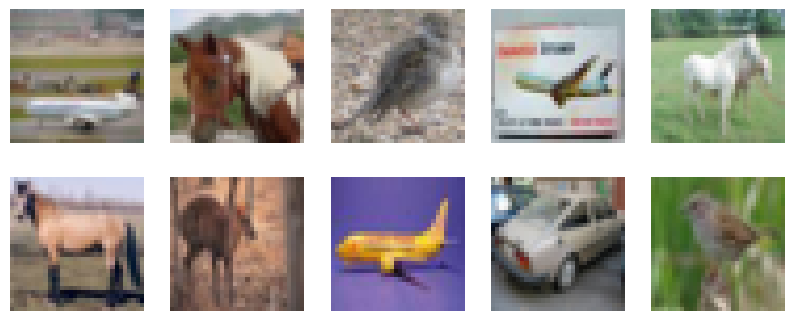

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10

num_classes = 10

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Visualizing CIFAR 10
fig, axes1 = plt.subplots(2,5,figsize=(10,4))
for j in range(2):
  for k in range(5):
    i = np.random.choice(range(len(x_train)))
    axes1[j][k].set_axis_off()
    axes1[j][k].imshow(x_train[i:i+1][0])
        
# Normalize
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [5]:
def visualize_loss_and_acc(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc = history_dict['accuracy']

  epochs = range(1, len(acc) + 1)

  f = plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()


  acc_values = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

#### Baseline

Define the baseline model

In [6]:
def get_baseline_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  
  return model

Train the baseline

In [7]:
batch_size = 32
epochs = 25

In [8]:
# Create the baseline model
baseline = get_baseline_model()

# Train model
bs_history = baseline.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    shuffle=True
)

Epoch 1/25
1563/1563 [==============================] - 89s 56ms/step - loss: 1.5468 - accuracy: 0.4329 - val_loss: 1.1844 - val_accuracy: 0.5786
Epoch 2/25
1563/1563 [==============================] - 86s 55ms/step - loss: 1.1450 - accuracy: 0.5926 - val_loss: 0.9374 - val_accuracy: 0.6705
Epoch 3/25
1563/1563 [==============================] - 83s 53ms/step - loss: 0.9810 - accuracy: 0.6531 - val_loss: 0.8830 - val_accuracy: 0.6889
Epoch 4/25
1563/1563 [==============================] - 88s 56ms/step - loss: 0.8866 - accuracy: 0.6901 - val_loss: 0.8060 - val_accuracy: 0.7239
Epoch 5/25
1563/1563 [==============================] - 87s 55ms/step - loss: 0.8236 - accuracy: 0.7108 - val_loss: 0.7598 - val_accuracy: 0.7394
Epoch 6/25
1563/1563 [==============================] - 88s 56ms/step - loss: 0.7770 - accuracy: 0.7275 - val_loss: 0.7396 - val_accuracy: 0.7479
Epoch 7/25
1563/1563 [==============================] - 87s 56ms/step - loss: 0.7351 - accuracy: 0.7430 - val_loss: 0.7022 -

Visualize the training and evaluate the model

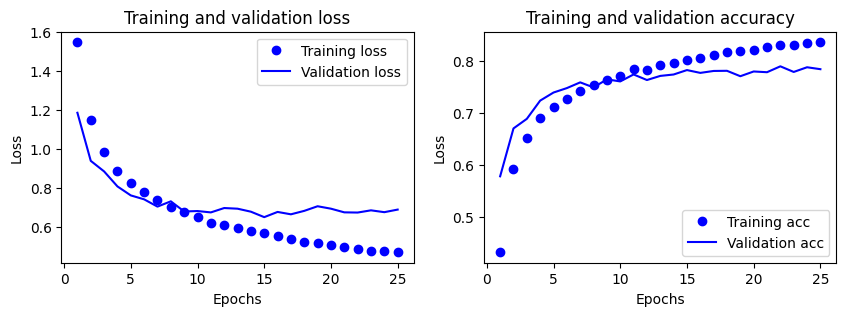

In [9]:
visualize_loss_and_acc(bs_history)

In [10]:
# Score trained model.
scores = baseline.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

313/313 [==============================] - 4s 14ms/step - loss: 0.6870 - accuracy: 0.7842
Test accuracy: 0.7842000126838684


#### Improved

Now update the baseline to create an enhanced model only by using `BatchNormalizedLayer` 

In [51]:
def get_improved_model():
  
  model = Sequential()
  
  model.add(Conv2D(32, (3, 3), padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(BatchNormalizedLayer(Conv2D(32, (3, 3)), activation='relu'))
  model.add(BatchNormalizedLayer(MaxPooling2D(pool_size=(2, 2)), activation='relu'))
  model.add(Dropout(0.25))

  model.add(BatchNormalizedLayer(Conv2D(64, (3, 3), padding='same')))
  model.add(BatchNormalizedLayer(Conv2D(64, (3, 3)), activation='relu'))
  model.add(BatchNormalizedLayer(MaxPooling2D(pool_size=(2, 2))))
  model.add(Dropout(0.25))

  model.add(BatchNormalizedLayer(Flatten()))
  model.add(BatchNormalizedLayer(Dense(512), activation='relu'))
  model.add(Dropout(0.5))


  model.add(BatchNormalizedLayer(Dense(num_classes), activation='softmax'))
  
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model


Train and evaluate

In [ ]:
# Create the baseline model
impv_model = get_improved_model()

# Train model
impv_history = impv_model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    shuffle=True
)

Visualize the training and evaluate the model

In [ ]:
visualize_loss_and_acc(impv_history)

In [ ]:
# Score trained model.
scores = impv_model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy:', scores[1])

In [ ]:
# Remember to run this cell after each time you update the model, 
# this is a deliverable item of your assignemnt
impv_model.save(str(r'INSERT LOCATION HERE'))


# References



1. Ioffe, Sergey, and Christian Szegedy. “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift.” ArXiv:1502.03167 [Cs], February 10, 2015. http://arxiv.org/abs/1502.03167.
* Im, Daniel Jiwoong, Michael Tao, and Kristin Branson. “An Empirical Analysis of the Optimization of Deep Network Loss Surfaces.” ArXiv:1612.04010 [Cs], December 12, 2016. http://arxiv.org/abs/1612.04010.
* Santurkar, Shibani, Dimitris Tsipras, Andrew Ilyas, and Aleksander Madry. “How Does Batch Normalization Help Optimization?” In Advances in Neural Information Processing Systems 31, edited by S. Bengio, H. Wallach, H. Larochelle, K. Grauman, N. Cesa-Bianchi, and R. Garnett, 2483–2493. Curran Associates, Inc., 2018. http://papers.nips.cc/paper/7515-how-does-batch-normalization-help-optimization.pdf.
* Coursera Course: Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization
* Intro to optimization in deep learning: Busting the myth about batch normalization [[link](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/)]
* Why Does Batch Normalization Work? [[link](https://abay.tech/blog/2018/07/01/why-does-batch-normalization-work/)]

